In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

In [ ]:
df = pd.read_csv('road_accident.csv')
df.columns = [c.strip() for c in df.columns]

In [ ]:
df.head()


,Date,Year,Time,Day_of_Week,Barangay,Latitude,Longitude,Weather,Road_Condition,Vehicle_Type,Driver_Age,Driver_Gender,Accident_Cause,Road_Accident_Type,Injuries,Fatalities
0,04/08/2021,2021,21:15,Wednesday,I-C (Bagong Bayan),14.071215,121.322198,Sunny,Dry,Motorcycle,44,Male,Head-on collision,Drunk Driving,4,0
1,20/08/2021,2021,7:15,Friday,Santa Veronica (Bae),14.080453,121.330692,Sunny,Dry,Bicycle,38,Male,Rear-end collision,Drunk Driving,1,1
2,05/09/2023,2023,3:32,Tuesday,I-A (Sambat),14.080712,121.301354,Rainy,Wet,Car,29,Female,Side-impact collision,Reckless Driving,2,0
3,14/12/2021,2021,15:08,Tuesday,VI-A (Mavenida),14.047567,121.298669,Rainy,Wet,Motorcycle,50,Male,Side-impact collision,Overloading,5,0
4,05/02/2020,2020,13:01,Wednesday,San Lucas 2 (Malinaw),14.080015,121.329899,Rainy,Wet,Motorcycle,27,Male,Head-on collision,Fatigue,2,0


In [ ]:
df.columns




Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Road_Condition', 'Vehicle_Type', 'Driver_Age',
       'Driver_Gender', 'Accident_Cause', 'Road_Accident_Type', 'Injuries',
       'Fatalities'],
      dtype='object')

In [ ]:
df.shape

(1500, 16)

In [ ]:
# Ensure required columns exist
required_cols = ['Year', 'Barangay', 'Road_Accident_Type', 'Accident_Cause', 'Fatalities']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

In [ ]:
# Define features and target
X = df[['Year', 'Barangay', 'Road_Accident_Type', 'Accident_Cause']]
y = df['Fatalities'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Barangay', 'Road_Accident_Type', 'Accident_Cause'])
    ],
    remainder='drop'
)

In [ ]:
# Full pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 1050, Test samples: 450


In [ ]:
# 6. Train
pipe.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:43:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay',
                                                   'Road_Accident_Type',
                                                   'Accident_Cause'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytr...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Make predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

In [ ]:
print("=== XGBoost - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== XGBoost - Classification Report ===
              precision    recall  f1-score   support

           0     0.8184    0.9216    0.8669       357
           1     0.4167    0.2151    0.2837        93

    accuracy                         0.7756       450
   macro avg     0.6175    0.5683    0.5753       450
weighted avg     0.7354    0.7756    0.7464       450



=== XGBoost - Confusion Matrix ===
[[329  28]
 [ 73  20]]


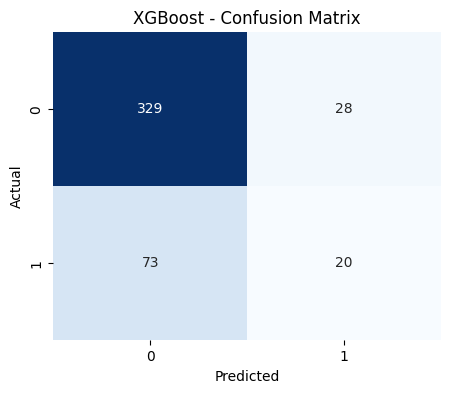

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== XGBoost - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== XGBoost - ROC AUC: 0.6351 ===


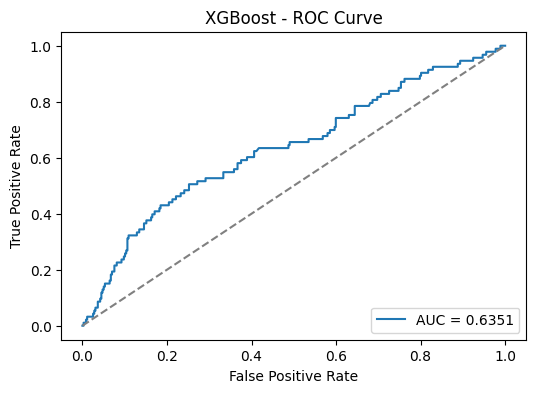

In [ ]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== XGBoost - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save model
joblib.dump(pipe, "road_predictor_xgb.pkl")
print("Saved model to road_predictor_xgb.pkl")

Saved model to road_predictor_xgb.pkl


After the installation is complete, please run the cell with the error again.

# Task
Train a Logistic Regression model to predict the occurrence of road accidents based on features like 'Road_Accident_Type' and 'Accident_Cause' using the dataset "Road_Accident_Data.csv".

## Data preparation

### Subtask:
Define the features (excluding 'Fatalities' and the non-predictive columns like 'Date' and 'Time') and the target variable (whether an accident occurred, which can be inferred from the dataset having entries only for accidents). Create a new binary target variable indicating the occurrence of an accident.


**Reasoning**:
Create the feature DataFrame by dropping the specified columns and create the binary target variable indicating accident occurrence.

